# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [8]:
# Run some setup code for this notebook.

import random
import numpy as np
# from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle
from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the raw CIFAR-10 data.
# cifar10_dir = 'cs231n/datasets/cifar-10-python/cifar-10-batches-py'
# X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# # As a sanity check, we print out the size of the training and test data.
# print('Training data shape: ', X_train.shape)
# print('Training labels shape: ', y_train.shape)
# print('Test data shape: ', X_test.shape)
# print('Test labels shape: ', y_test.shape)
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target.reshape((-1, 1))
print(X.shape, y.shape)

(150, 2) (150, 1)


In [9]:
X, y = shuffle(iris.data, iris.target, random_state=13)
X = X.astype(np.float32)

# 训练集与测试集的简单划分
offset = int(X.shape[0] * 0.7)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

print('X_train=', X_train.shape)
print('X_test=', X_test.shape)
print('y_train=', y_train.shape)
print('y_test=', y_test.shape)

X_train= (105, 4)
X_test= (45, 4)
y_train= (105, 1)
y_test= (45, 1)


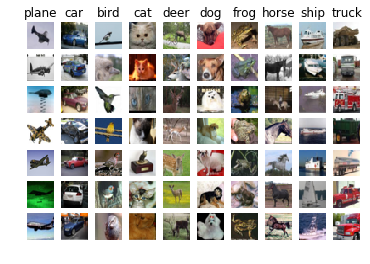

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [10]:
from k_nearest_neighbor import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [11]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(45, 105)


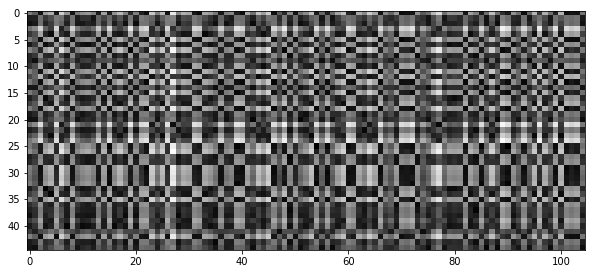

In [12]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



In [20]:
y_test_pred = classifier.predict_labels(dists, k=1)
y_test_pred = y_test_pred.reshape((-1, 1))
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('Got %d / %d correct => accuracy: %f' % (num_correct, X_test.shape[0], accuracy))

Got 44 / 45 correct => accuracy: 0.977778


In [23]:
print(y_test.shape, y_test_pred.shape)

(45, 1) (45, 1)


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [26]:
y_test_pred = classifier.predict_labels(dists, k=5)
y_test_pred = y_test_pred.reshape((-1, 1))
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('Got %d / %d correct => accuracy: %f' % (num_correct, X_test.shape[0], accuracy))

Got 44 / 45 correct => accuracy: 0.977778


You should expect to see a slightly better performance than with `k = 1`.

In [14]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [15]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [16]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 28.127807 seconds
One loop version took 112.870033 seconds
No loop version took 0.805844 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [28]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {}



for k in k_choices:
    for fold in range(num_folds): #This fold will be omitted.
        #Creating validation data and temp training data
        validation_X_test = X_train_folds[fold]
        validation_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])

        #Initializing a class
        test_classifier = KNearestNeighbor()
        test_classifier.train( temp_X_train, temp_y_train )
        
        #Computing the distance
        temp_dists = test_classifier.compute_distances_two_loops(validation_X_test)
        temp_y_test_pred = test_classifier.predict_labels(temp_dists, k=k)
        temp_y_test_pred = temp_y_test_pred.reshape((-1, 1))
        #Checking accuracies
        num_correct = np.sum(temp_y_test_pred == validation_y_test)
        num_test = validation_X_test.shape[0]
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k] = k_to_accuracies.get(k,[]) + [accuracy]
    


# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.904762
k = 1, accuracy = 1.000000
k = 1, accuracy = 0.952381
k = 1, accuracy = 0.857143
k = 1, accuracy = 0.952381
k = 3, accuracy = 0.857143
k = 3, accuracy = 1.000000
k = 3, accuracy = 0.952381
k = 3, accuracy = 0.857143
k = 3, accuracy = 0.952381
k = 5, accuracy = 0.857143
k = 5, accuracy = 1.000000
k = 5, accuracy = 0.952381
k = 5, accuracy = 0.904762
k = 5, accuracy = 0.952381
k = 8, accuracy = 0.904762
k = 8, accuracy = 1.000000
k = 8, accuracy = 0.952381
k = 8, accuracy = 0.904762
k = 8, accuracy = 0.952381
k = 10, accuracy = 0.952381
k = 10, accuracy = 1.000000
k = 10, accuracy = 0.952381
k = 10, accuracy = 0.904762
k = 10, accuracy = 0.952381
k = 12, accuracy = 0.952381
k = 12, accuracy = 1.000000
k = 12, accuracy = 0.952381
k = 12, accuracy = 0.857143
k = 12, accuracy = 0.952381
k = 15, accuracy = 0.952381
k = 15, accuracy = 1.000000
k = 15, accuracy = 0.952381
k = 15, accuracy = 0.857143
k = 15, accuracy = 0.952381
k = 20, accuracy = 0.952381
k = 20, accu

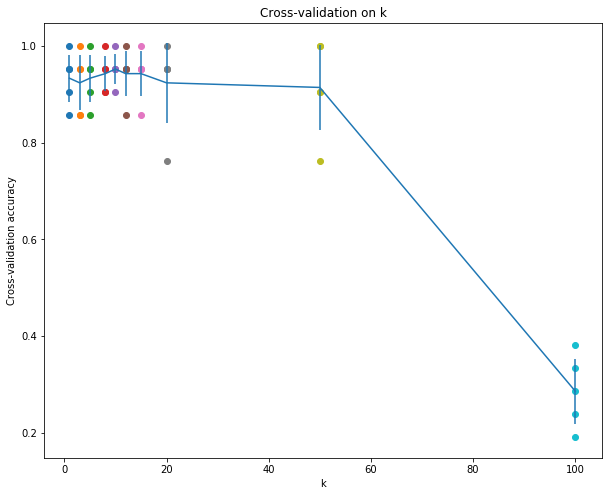

In [29]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [44]:
best_k = k_choices[np.argmax(accuracies_mean)]
print(best_k)

10


In [35]:
best_k

10

In [43]:
import numpy as np
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


class KNearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just 
        memorizing the training data.

        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    
    def compute_distances(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 

        M = np.dot(X, self.X_train.T)
        te = np.square(X).sum(axis=1)
        tr = np.square(self.X_train).sum(axis=1)
        dists = np.sqrt(-2 * M + tr + np.matrix(te).T)
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].  
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):

            closest_y = []
            labels = self.y_train[np.argsort(dists[i, :])].flatten()
            closest_y = labels[0:k]

            c = Counter(closest_y)
            y_pred[i] = c.most_common(1)[0][0]

        return y_pred
    
    def cross_validation(self, X_train, y_train):
        num_folds = 5
        k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

        X_train_folds = []
        y_train_folds = []

        X_train_folds = np.array_split(X_train, num_folds)
        y_train_folds = np.array_split(y_train, num_folds)

        k_to_accuracies = {}

        for k in k_choices:
            for fold in range(num_folds): #This fold will be omitted.
                #Creating validation data and temp training data
                validation_X_test = X_train_folds[fold]
                validation_y_test = y_train_folds[fold]
                temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
                temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])

                #Initializing a class
                self.train(temp_X_train, temp_y_train )

                #Computing the distance
                temp_dists = self.compute_distances(validation_X_test)
                temp_y_test_pred = self.predict_labels(temp_dists, k=k)
                temp_y_test_pred = temp_y_test_pred.reshape((-1, 1))
                #Checking accuracies
                num_correct = np.sum(temp_y_test_pred == validation_y_test)
                num_test = validation_X_test.shape[0]
                accuracy = float(num_correct) / num_test
                k_to_accuracies[k] = k_to_accuracies.get(k,[]) + [accuracy]

        # Print out the computed accuracies
        for k in sorted(k_to_accuracies):
            for accuracy in k_to_accuracies[k]:
                print('k = %d, accuracy = %f' % (k, accuracy))
                
        accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
        best_k = k_choices[np.argmax(accuracies_mean)]
        print('最佳k值为{}'.format(best_k))
        return best_k
        
        
    def create_train_test(self):
        X, y = shuffle(iris.data, iris.target, random_state=13)
        X = X.astype(np.float32)
        y = y.reshape((-1,1))
        offset = int(X.shape[0] * 0.7)
        X_train, y_train = X[:offset], y[:offset]
        X_test, y_test = X[offset:], y[offset:]
        y_train = y_train.reshape((-1,1))
        y_test = y_test.reshape((-1,1))
        return X_train, y_train, X_test, y_test

        
if __name__ == '__main__':
    knn_classifier = KNearestNeighbor()
    X_train, y_train, X_test, y_test = knn_classifier.create_train_test()
    best_k = knn_classifier.cross_validation(X_train, y_train)
    dists = knn_classifier.compute_distances(X_test)
    y_test_pred = knn_classifier.predict_labels(dists, k=best_k)
    y_test_pred = y_test_pred.reshape((-1, 1))
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / X_test.shape[0]
    print('Got %d / %d correct => accuracy: %f' % (num_correct, X_test.shape[0], accuracy))

k = 1, accuracy = 0.904762
k = 1, accuracy = 1.000000
k = 1, accuracy = 0.952381
k = 1, accuracy = 0.857143
k = 1, accuracy = 0.952381
k = 3, accuracy = 0.857143
k = 3, accuracy = 1.000000
k = 3, accuracy = 0.952381
k = 3, accuracy = 0.857143
k = 3, accuracy = 0.952381
k = 5, accuracy = 0.857143
k = 5, accuracy = 1.000000
k = 5, accuracy = 0.952381
k = 5, accuracy = 0.904762
k = 5, accuracy = 0.952381
k = 8, accuracy = 0.904762
k = 8, accuracy = 1.000000
k = 8, accuracy = 0.952381
k = 8, accuracy = 0.904762
k = 8, accuracy = 0.952381
k = 10, accuracy = 0.952381
k = 10, accuracy = 1.000000
k = 10, accuracy = 0.952381
k = 10, accuracy = 0.904762
k = 10, accuracy = 0.952381
k = 12, accuracy = 0.952381
k = 12, accuracy = 1.000000
k = 12, accuracy = 0.952381
k = 12, accuracy = 0.857143
k = 12, accuracy = 0.952381
k = 15, accuracy = 0.952381
k = 15, accuracy = 1.000000
k = 15, accuracy = 0.952381
k = 15, accuracy = 0.857143
k = 15, accuracy = 0.952381
k = 20, accuracy = 0.952381
k = 20, accu